In [1]:
import numpy as np
import pandas as pd
import json

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
metadata = pd.read_csv('DES_VT_Subject_Export.csv')
metadata = metadata[metadata['workflow_id'] == 25011]
ok_class = ['single_cand', 'double_cand', 'inter_cand']
subject_ids, my_ids, cand_class = [], [], []

for (index, row) in metadata.iterrows():
    data_tmp = json.loads(row['metadata'])#[str(row['subject_ids'])]
    if(not(data_tmp['#CLASS'] in ok_class)):
        continue
    cand_class.append(data_tmp['#CLASS'])
    subject_ids.append(int(row['subject_id']))
    my_ids.append(int(data_tmp['#NEW_ID']))

In [3]:
complete_metadata = pd.DataFrame()
complete_metadata['class'] = cand_class
complete_metadata['subject_id'] = subject_ids
complete_metadata['my_ids'] = my_ids

complete_metadata = complete_metadata.drop_duplicates()
print(len(complete_metadata))
complete_metadata.head()

22564


,class,subject_id,my_ids
0,double_cand,92396146,0
1,double_cand,92396147,1
2,double_cand,92396148,2
3,double_cand,92396149,3
4,double_cand,92396150,4


In [4]:
#results = pd.read_csv('DES_VT_Subjects_26_Oct_1600_BST.csv')
results = pd.read_csv('DES_VT_Subjects_3_Nov_1700_BST.csv')
#results = pd.read_csv('DES_VT_Subjects_19_Oct_1700_BST.csv')
#results = pd.read_csv('DES_VT_Subjects_18_Oct_1800_BST.csv')

mask = complete_metadata['subject_id'].isin(results['subject_id'])
complete_metadata[mask]

key_data = complete_metadata.merge(results[['subject_id', 'score']], on='subject_id', how='left').dropna()
key_data = key_data.rename({'my_ids': '#NEW_ID'}, axis=1)
print(len(key_data))
key_data.tail()

22564


,class,subject_id,#NEW_ID,score
22559,single_cand,92418733,20021,0.000005
22560,single_cand,92418734,20022,0.000190
22561,single_cand,92418735,20023,1.000000
22562,single_cand,92418736,20025,0.000004
22563,single_cand,92418737,20024,0.000002


In [5]:
file_path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/Results/fits_files/'

# Writes fit file
def write_fit_file(name, x, data, type_data):
    rename_dict = {'#NEW_ID': 'NEW_ID', '#CLASS': 'CLASS', '#REPORTED': 'REPORTED', '#REF': 'REF',
       'subject_id': 'SUBJECT_ID', 'score': 'SCORE'}
    data = data.rename(rename_dict , axis=1)
    
    my_types = {'COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int, 'IMAFLAGS_ISO_R': int, 'IMAFLAGS_ISO_I': int,
       'IMAFLAGS_ISO_Z': int, 'EXT_COADD': int, 'NEW_ID': int, 'CLASS': str, 'REPORTED': bool,
       'SUBJECT_ID': int, 'SCORE': float}
    if(type_data == 'inter'):
        tmp_types = {'PROB_SING': float, 'PROB_DOUB': float}
        my_types.update(tmp_types)
    elif(type_data == 'all'):
        tmp_types = {'PROB_SING': float, 'PROB_DOUB': float, 'PROB': float}
        my_types.update(tmp_types)
    else:
        tmp_types = {'PROB': float}
        my_types.update(tmp_types)
        
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto(file_path + name + '.fits', overwrite=True)   
    hdu_list.close()

In [6]:
def make_plot_all(objects, title, data, Q, stretch, minimum):
    for i in range(len(objects)):
        if(i%7 == 0):
            plt.figure(figsize=(12,2))
            for j in range(7):
                if(i+j > len(objects)-1): break
                plt.subplot(1,7,j+1)
                expo = "{:e}".format(data['score'].iloc[i+j]).split('e')[1]
                reported = 'T' if data['#REPORTED'].iloc[i+j] else 'F'
                color = 'lime' if data['#REPORTED'].iloc[i+j] else 'aqua'
                title = '{:.7f} {}'.format(data['score'].iloc[i+j], reported)
                #plt.title(title, color=color)
                #print(data['COADD_OBJECT_ID'].iloc[i+j]) 
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], 
                                    Q=Q, stretch=stretch, minimum=minimum)
                rgb = np.flipud(rgb)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.savefig(str(i+j) + '.png', bbox_inches='tight')
        plt.show() 
        
def make_plot_all2(objects, title, data, Q, stretch, minimum):
    for i in range(len(objects)):
        if(i%7 == 0):
            plt.figure(figsize=(12,2))
            for j in range(7):
                if(i+j > len(objects)-1): break
                plt.subplot(1,7,j+1)
                expo = "{:e}".format(data['score'].iloc[i+j]).split('e')[1]
                reported = 'T' if data['#REPORTED'].iloc[i+j] else 'F'
                color = 'lime' if data['#REPORTED'].iloc[i+j] else 'aqua'
                title = '{:.7f} {}'.format(data['PROB'].iloc[i+j], reported)
                plt.title(title, color=color)
                #print(data['COADD_OBJECT_ID'].iloc[i+j]) 
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], 
                                    Q=Q, stretch=stretch, minimum=minimum)
                rgb = np.flipud(rgb)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            #plt.savefig(png_filepath + title + '.png', bbox_inches='tight')
        plt.show() 

1928
1928


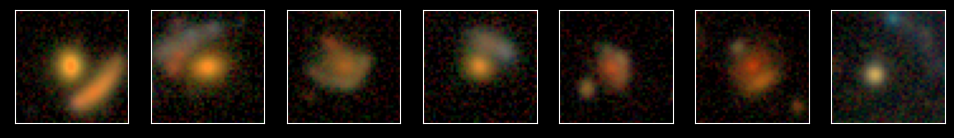

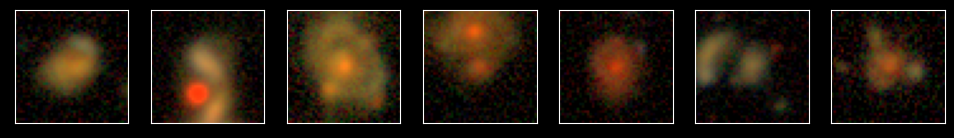

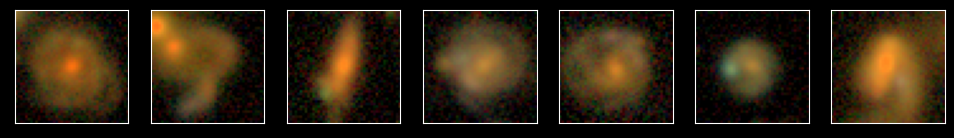

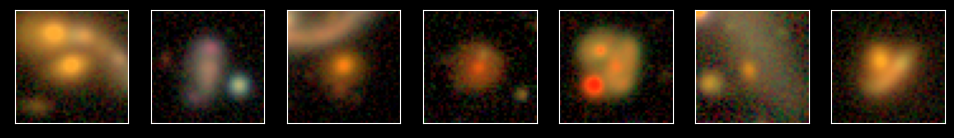

In [7]:
#double candidates
path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/fit_files/'
mani_path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/to_upload/'

hdu_list = fits.open(path + 'double.fits')
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
key_data_tmp = key_data[key_data['class'] == 'double_cand']
print(len(data))

data_mani = pd.read_csv(mani_path + 'double/doub_complete_manifest.csv')

data = data.merge(data_mani[['COADD_OBJECT_ID', '#NEW_ID', '#CLASS', '#REPORTED']], on='COADD_OBJECT_ID', how='left').dropna()
data = data.merge(key_data_tmp[['#NEW_ID', 'subject_id', 'score']], on='#NEW_ID', how='left').dropna()
print(len(data))

new_data = data.sort_values(by='score', ascending=False)
images = images[new_data.index]
data = new_data.reset_index(drop=True)
data.to_csv('complete_double.csv', index=False)
write_fit_file('double', images, data, 'double')

images_doub, data_doub = images, data

n = 28
make_plot_all(images[0:n], 'title', data.iloc[0:n], 9, 45, (0, 0, 0))

610
610


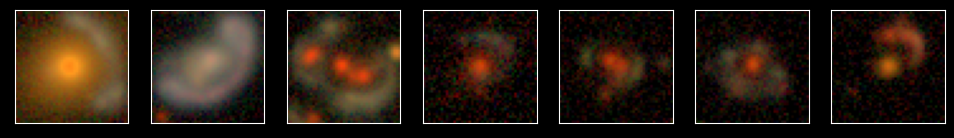

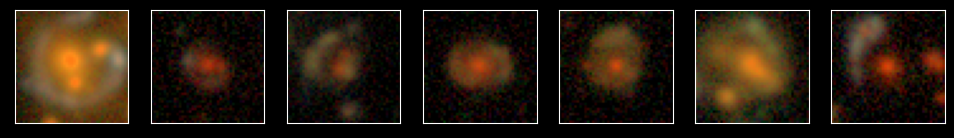

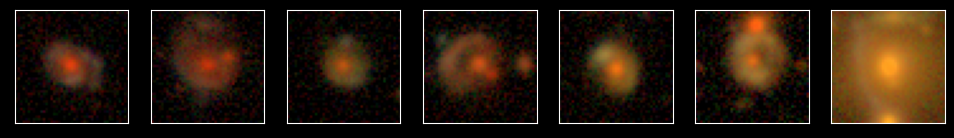

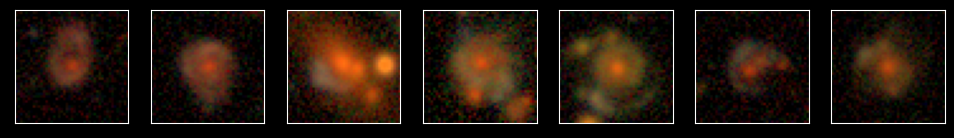

In [8]:
#candidates in intersection
path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/fit_files/'
mani_path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/to_upload/'

hdu_list = fits.open(path + 'inter.fits')
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
key_data_tmp = key_data[key_data['class'] == 'inter_cand']
print(len(data))

data_mani = pd.read_csv(mani_path + 'inter/inter_complete_manifest.csv')

data = data.merge(data_mani[['COADD_OBJECT_ID', '#NEW_ID', '#CLASS', '#REPORTED']], on='COADD_OBJECT_ID', how='left').dropna()
data = data.merge(key_data_tmp[['#NEW_ID', 'subject_id', 'score']], on='#NEW_ID', how='left').dropna()
print(len(data))

new_data = data.sort_values(by='score', ascending=False)
images = images[new_data.index]
data = new_data.reset_index(drop=True)
data.to_csv('complete_inter.csv', index=False)
write_fit_file('inter', images, data, 'inter')

images_inter, data_inter = images, data

n = 28
make_plot_all(images[0:n], 'title', data.iloc[0:n], 9, 45, (0, 0, 0))

In [9]:
#single candidates
path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/fit_files/'
mani_path = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/candidates/to_upload/'

hdu_list = fits.open(path + 'single.fits')
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
key_data_tmp = key_data[key_data['class'] == 'single_cand']
print(len(data))

data_mani = pd.read_csv(mani_path + 'single/sing_complete_manifest.csv')

data = data.merge(data_mani[['COADD_OBJECT_ID', '#NEW_ID', '#CLASS', '#REPORTED']], on='COADD_OBJECT_ID', how='left').dropna()
data = data.merge(key_data_tmp[['#NEW_ID', 'subject_id', 'score']], on='#NEW_ID', how='left').dropna()
print(len(data))

new_data = data.sort_values(by='score', ascending=False)
images = images[new_data.index]
data = new_data.reset_index(drop=True)
data.to_csv('complete_single.csv', index=False)

write_fit_file('single', images, data, 'single')

images_sing, data_sing = images, data

20026
20026


1857
2280


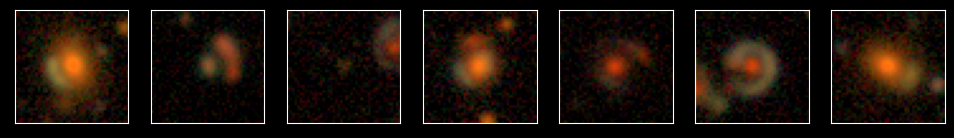

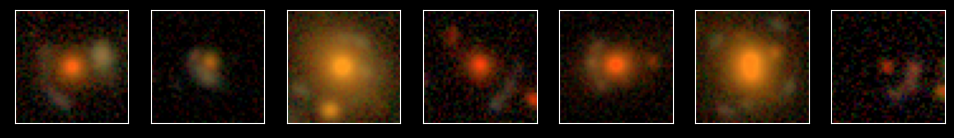

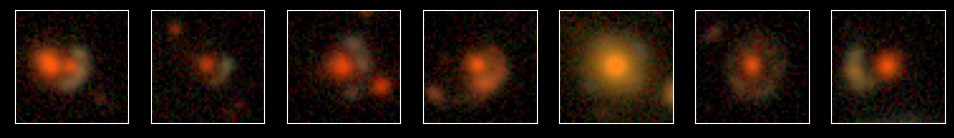

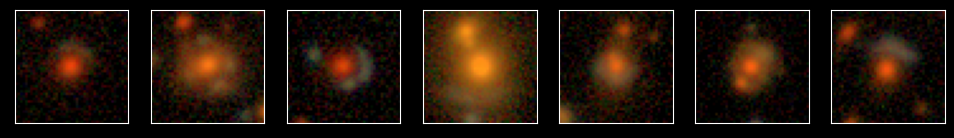

In [10]:
print(len(data[data['score'] > 0.9]))
print(len(data[data['score'] > 0.003]))
n = 28
make_plot_all(images[0:n], 'title', data.iloc[0:n], 9, 45, (0, 0, 0))

18675


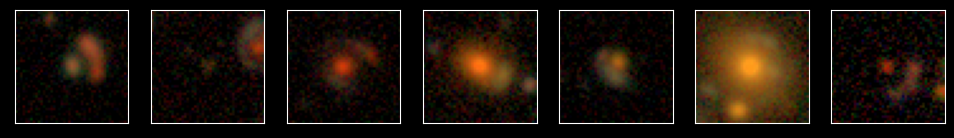

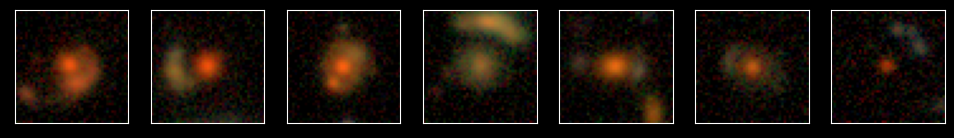

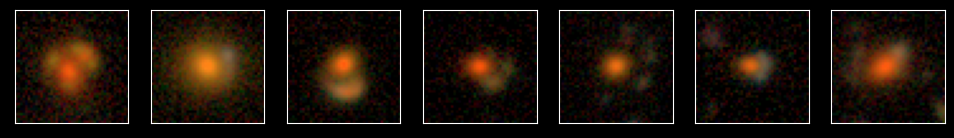

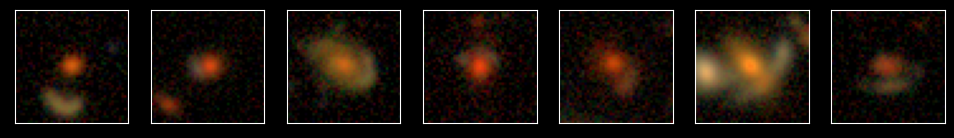

In [11]:
data_tmp = data[data['#REPORTED'] == False]
print(len(data_tmp))
images_tmp = images[data_tmp.index]
n = 28 #len(data_tmp)
make_plot_all(images_tmp[0:n], 'title', data_tmp.iloc[0:n], 9, 45, (0, 0, 0))

28


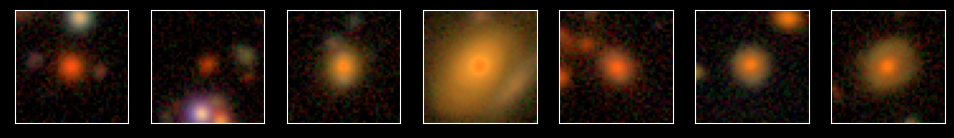

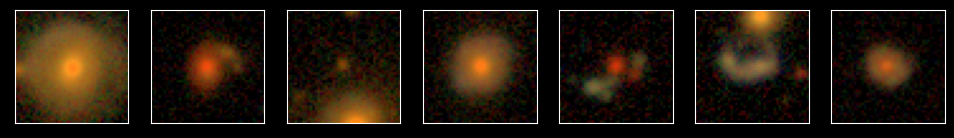

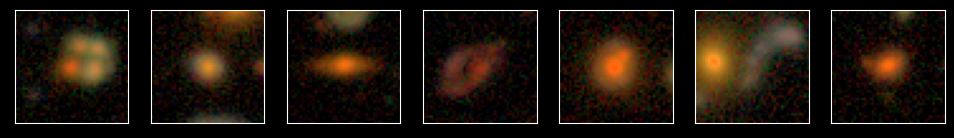

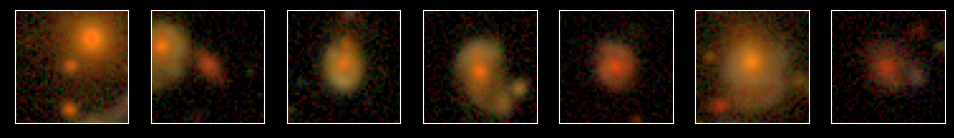

In [12]:
n = 28
data_tmp = data[data['#REPORTED'] == True]
images_tmp = images[data_tmp.index]

data_tmp = data_tmp.iloc[-n:]
data_tmp = data_tmp.sort_values(by='score', ascending=True)
#data_tmp = data_tmp.sort_values(by='PROB', ascending=True)
images_tmp = images[data_tmp.index]

print(len(data_tmp))
make_plot_all(images_tmp[0:n], 'title', data_tmp.iloc[0:n], 9, 45, (0, 0, 0))

In [13]:
data = pd.concat((data_sing, data_doub, data_inter))
data.fillna(-1, inplace=True)

images = np.concatenate((images_sing, images_doub, images_inter)).astype(np.float32)

write_fit_file('all_subjects', images, data, 'all')